# Gesture Recognition
#### Submitted by
- Sameer Soin
- Ayush Mandowara

## Problem Statement

A smart tv manufactures wants to add gesture based controls to their TVs. 

To start with, the following 5 gestures are planned to be undstood by the TV:
- Thumbs Up to increase volume
- Thumbs Down to decrease volume
- Left Swipe to move 10 seconds back
- Right Swipe to move 10 seconds ahead
- Open Palm (Stop) to pause

The hardware and software to capture and take action based on the gestures already exists with the manufacturer, our focus will be on `Recognising the Gestures`.

## Data
- The data we have been provided with to train our model consists of images / frames taken in a sequence (videos that are already broken down into images) for various individuals showing the above mentioned hand gestures.  
- The data is labelled with the different classes (gestures) that need to be identified.

## Approach
To do this, we will be using `Deep Learning`. Specifically, we will be trying two approaches:
- Approach 1: 3D CNN Model  
- Approach 2: A CNN + RNN Model


---

# Imports

In [2]:
import cv2
import datetime
import numpy as np
import os
import pandas as pd
import random as rn

from keras import backend as K
import tensorflow as tf
from cv2 import imread
from sklearn.utils import shuffle

import matplotlib.pyplot as plt

### Fixed Random Seeds
- This helps in reproducing results in subsequent runs

In [3]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

## Reading the Data
- The data is labelled
- The file paths along with labels are stored in csv files
- Data is already divided into train and validation folders 

In [4]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())

project_root = "Project_data"
train_folder = os.path.join(project_root, "train")
val_folder = os.path.join(project_root, "val")

In [5]:
train_doc[0]

'WIN_20180925_18_23_57_Pro_Thumbs_Down_new;Thumbs_Down_new;3\n'

In [6]:
len(train_doc)

663

In [7]:
train_df = pd.read_csv('Project_data/train.csv', delimiter=';', names=['Video Folder', 'Gesture', 'Label'])

In [8]:
len(train_df)

663

In [9]:
train_df.head(3)

,Video Folder,Gesture,Label
0,WIN_20180925_17_08_43_Pro_Left_Swipe_new,Left_Swipe_new,0
1,WIN_20180925_17_18_28_Pro_Left_Swipe_new,Left_Swipe_new,0
2,WIN_20180925_17_18_56_Pro_Left_Swipe_new,Left_Swipe_new,0


In [10]:
train_df.tail(3)

,Video Folder,Gesture,Label
660,WIN_20180907_16_42_05_Pro_Thumbs Up_new,Thumbs Up_new,4
661,WIN_20180907_16_42_55_Pro_Thumbs Up_new,Thumbs Up_new,4
662,WIN_20180907_16_43_39_Pro_Thumbs Up_new,Thumbs Up_new,4


In [11]:
val_df = pd.read_csv('Project_data/val.csv', delimiter=';', names=['Video Folder', 'Gesture', 'Label'])

In [12]:
val_df.head(3)

,Video Folder,Gesture,Label
0,WIN_20180925_17_17_04_Pro_Left_Swipe_new,Left_Swipe_new,0
1,WIN_20180925_17_43_01_Pro_Left_Swipe_new,Left_Swipe_new,0
2,WIN_20180925_18_01_40_Pro_Left_Swipe_new,Left_Swipe_new,0


In [13]:
val_df.tail(3)

,Video Folder,Gesture,Label
97,WIN_20180907_15_54_30_Pro_Thumbs Up_new,Thumbs Up_new,4
98,WIN_20180907_16_10_59_Pro_Thumbs Up_new,Thumbs Up_new,4
99,WIN_20180907_16_39_59_Pro_Thumbs Up_new,Thumbs Up_new,4


In [14]:
train_df = shuffle(train_df, random_state=RANDOM_SEED)

In [15]:
train_df.head(5)

,Video Folder,Gesture,Label
327,WIN_20180925_18_23_57_Pro_Thumbs_Down_new,Thumbs_Down_new,3
579,WIN_20180907_16_21_11_Pro_Stop Gesture_new,Stop Gesture_new,2
513,WIN_20180907_16_38_29_Pro_Left Swipe_new_Left ...,Left Swipe_new_Left Swipe_new,0
362,WIN_20180926_17_23_38_Pro_Thumbs_Down_new,Thumbs_Down_new,3
265,WIN_20180926_17_21_49_Pro_Stop_new,Stop_new,2


In [16]:
val_df = shuffle(val_df, random_state=RANDOM_SEED)

In [17]:
val_df.head(5)

,Video Folder,Gesture,Label
83,WIN_20180907_16_30_54_Pro_Stop Gesture_new,Stop Gesture_new,2
53,WIN_20180925_17_38_43_Pro_Thumbs_Up_new,Thumbs_Up_new,4
70,WIN_20180907_15_55_06_Pro_Right Swipe_new,Right Swipe_new,1
45,WIN_20180926_16_57_50_Pro_Thumbs_Down_new,Thumbs_Down_new,3
44,WIN_20180926_16_44_04_Pro_Thumbs_Down_new,Thumbs_Down_new,3


In [18]:
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

### Display a sequence

In [19]:
train_df.head(1)

,Video Folder,Gesture,Label
0,WIN_20180925_18_23_57_Pro_Thumbs_Down_new,Thumbs_Down_new,3


In [34]:
def get_video_path_train(idx):
    video_name = train_df.iloc[idx]['Video Folder']
    video_path = os.path.join(train_folder, video_name)
    return video_path

def get_image_list_train(idx):
    ims = os.listdir(get_video_path_train(idx))
    return ims

In [35]:
get_video_path_train(0)

'Project_data\\train\\WIN_20180925_18_23_57_Pro_Thumbs_Down_new'

In [36]:
ims = get_image_list_train(0)

In [37]:
len(ims)

30

In [42]:
def plot_sequence(train_idx, rows=3, columns=10, fig_size=(20,3), step_size=1):
    fig = plt.figure(figsize=fig_size)
    ims = get_image_list_train(train_idx)
    folder_path = get_video_path_train(train_idx)
    
    for i in range(1, columns*rows+1, step_size):
        img = imread(os.path.join(folder_path, ims[i-1]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)

    plt.show()

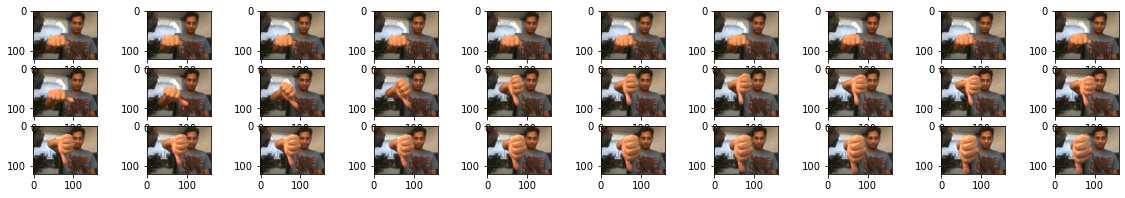

In [43]:
plot_sequence(0)

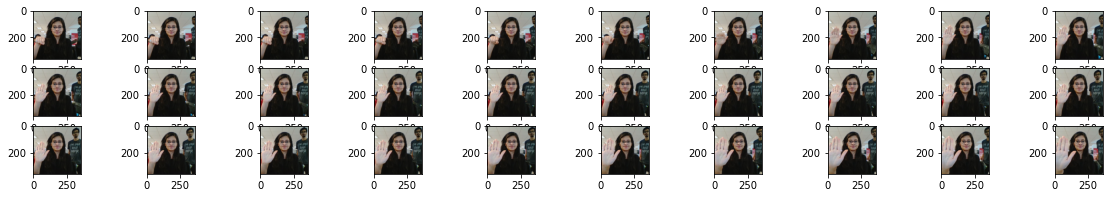

In [47]:
plot_sequence(1)

### Checking GPU Specs

In [195]:
# !nvidia-smi

# Generator

### Problems
- Since the data is huge, it cannot be processed in a single go. The machine will throw out of memory error.
- There are images in two types (dimension 120x120 and 360x), we need to make the dimensions same
- There is some room for skipping images to speed up the training process
- Data augmentation may be required to increase accuracy
- Ablation will be required to reduce analysis time

### Solution
All of the above can be achieved with the help of a custom generator which generates data in batches as per requirement.

In [68]:
class ImageProps:
    """Image class to easily store, retrieve and update properties of input images during training"""
    img_selection_via_idx = [3, 6, 9, 12, 15, 18, 21]
    img_selection_len = len(img_selection_via_idx)
    img_height = 80
    img_width = 80

In [71]:
img_obj = ImageProps()

In [72]:
img_obj.img_selection_via_idx

[3, 6, 9, 12, 15, 18, 21]

In [129]:
class VideoBatchGenerator:
    """Generator class to generate images in batches as per requirement"""
    batch_size = 663
    
    def batch_generator(self, parent_folder_path, video_folder_list):
        print(f"Source Path: {parent_folder_path}")
        num_videos = len(video_folder_list)
        print(f"Number of Videos: {num_videos}")
        print(f"Batch Size: {self.batch_size}") 
        
        num_batches = num_videos//self.batch_size
        print(f"Number of Batches: {num_batches}")
        
        while True:
            shuffled_video_folders = np.random.permutation(video_folder_list)
            
            # print(t)
            yield shuffled_video_folders
            

In [130]:
v = VideoBatchGenerator()

In [131]:
x = v.batch_generator('t', train_df['Video Folder'])

In [132]:
len(next(x))

Source Path: t
Number of Videos: 663
Batch Size: 663
Number of Batches: 1


663